# DBSCAN | 하이퍼 파라미터 튜닝

In [1]:
from hossam import load_data, my_dpi
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from scipy.spatial import ConvexHull
from kneed import KneeLocator

#성능평가 지표
from hossam import visualize_silhouette

c:\Users\wodyd\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 아이티윌 이광호 강사가 제작한 라이브러리를 사용중입니다.
📚 자세한 사용 방법은 https://py.hossam.kr 을 참고하세요.
📧 Email: leekh4232@gmail.com
🎬 Youtube: https://www.youtube.com/@hossam-codingclub
📝 Blog: https://blog.hossam.kr/
🔖 Version: 0.4.9


In [ ]:
origin = load_data('game_usage')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()


게임 이용시간(time spent)과 레벨(game level)에 대한 가상 데이터
데이터셋 크기: (100, 2)
열 개수: 2
행 개수: 100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   time spent  100 non-null    int64
 1   game level  100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB
None


,time spent,game level
0,39,944
1,55,705
2,29,757
3,59,999
4,7,109


In [7]:
scaler = StandardScaler()
df = DataFrame(scaler.fit_transform(origin), columns = origin.columns)
df.head()

,time spent,game level
0,-0.250733,1.474805
1,0.326494,0.606546
2,-0.611500,0.795456
3,0.470801,1.674613
4,-1.405187,-1.558652


In [5]:
min_samples = 3

## k개의 최근접 이웃 만들기



In [9]:
# 'k = min_samples' 설정
k = min_samples

# 각 점에 대해 k번쨰 최근점 이웃 거리 계산
neighbors = NearestNeighbors(n_neighbors = k)
neighbors_fit = neighbors.fit(df)
distance, indices = neighbors_fit.kneighbors(df)

# 모든 점의 거리 값을 가까운 순서대로 정렬(오름차순)
s_distance = np.sort(distance, axis = 0)

# 각 데이터 포인트로부터의 거리 추출
target = s_distance[:, k-1]
target

array([0.10111015, 0.11039822, 0.11625223, 0.11988511, 0.12172144,
       0.12285113, 0.12769295, 0.12769295, 0.12836733, 0.12836733,
       0.12836733, 0.14619664, 0.14620339, 0.14936701, 0.14972662,
       0.14972662, 0.15325497, 0.15557345, 0.15678809, 0.15678809,
       0.15843153, 0.1588343 , 0.16323203, 0.16697634, 0.16697634,
       0.17807115, 0.17867241, 0.17867241, 0.1803835 , 0.18096788,
       0.18305073, 0.18332275, 0.18890987, 0.18890987, 0.19313888,
       0.19721127, 0.20223342, 0.2034414 , 0.2034414 , 0.21075165,
       0.21265306, 0.2164602 , 0.21735497, 0.21735497, 0.21840257,
       0.21891561, 0.22011805, 0.22405052, 0.22412868, 0.22412868,
       0.2293733 , 0.23202731, 0.23336017, 0.23997564, 0.24073719,
       0.24336383, 0.25066886, 0.25104255, 0.25735751, 0.25735751,
       0.26275573, 0.26444959, 0.26650157, 0.268372  , 0.27569735,
       0.27651041, 0.28918464, 0.28923923, 0.29007322, 0.29212993,
       0.29212993, 0.29240678, 0.29286115, 0.30298035, 0.31153

## 그래프에서 꺾이는 지점 확인(Elbow Point)
### eps값 찾기(Elbow Point)

In [10]:
kl = KneeLocator(range(0, len(target)), target, curve = 'convex', direction = 'increasing')
eps = kl.elbow_y
point = kl.elbow
print('found elbow: ', eps)
print('found point:', point)

found elbow:  0.41251429498079606
found point: 91


### 시각화

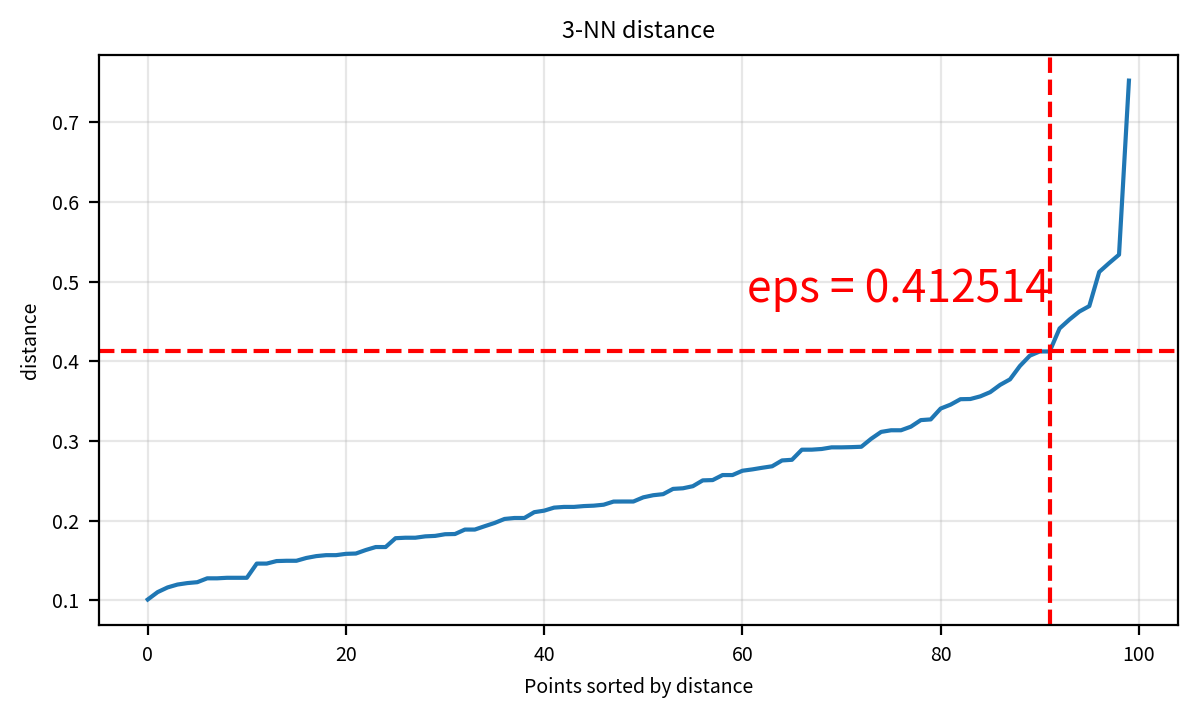

In [16]:
width_px = 1200
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# box 그리기
sb.lineplot(x = range(0, len(target)), y =target)
ax.axhline(eps, color = 'r', linestyle = '--')
ax.axvline(point, color = 'r', linestyle = '--')
ax.text(
    point, eps + 0.05, 'eps = %f' % eps, fontsize = 16, color = 'r', va = 'bottom', ha = 'right'
)

ax.set_title('%d-NN distance' % k)
ax.set_ylabel('distance')
ax.set_xlabel('Points sorted by distance')
ax.grid(True, alpha = 0.3)
# 그래프 꾸미기
ax.grid(True) 

# 출력
plt.tight_layout()
plt.show()
plt.close()

## 2. 도출된 eps와 k값을 활용한 군집
### 1. 군집 모형 적합

In [17]:
estimator = DBSCAN(eps = eps, min_samples = k, n_jobs = -1)
estimator.fit(df)

result_df = df.copy()
result_df['cluster'] = estimator.labels_
result_df.head()

,time spent,game level,cluster
0,-0.250733,1.474805,0
1,0.326494,0.606546,0
2,-0.611500,0.795456,0
3,0.470801,1.674613,1
4,-1.405187,-1.558652,2


### 2. 벡터 종류 기본

In [18]:
result_df2 = result_df.copy()

# 기본적으로 모두 외곽 벡터로 지정
result_df2['vector'] = 'border'

# 핵심 벡터인 경우 'core'로 지정
result_df2.loc[estimator.core_sample_indices_, 'vector'] = 'core'

# 노이즈 분류
result_df2.loc[result_df2['cluster'] == -1, 'vector'] = 'noise'

result_df2.head()

,time spent,game level,cluster,vector
0,-0.250733,1.474805,0,core
1,0.326494,0.606546,0,core
2,-0.611500,0.795456,0,core
3,0.470801,1.674613,1,core
4,-1.405187,-1.558652,2,core


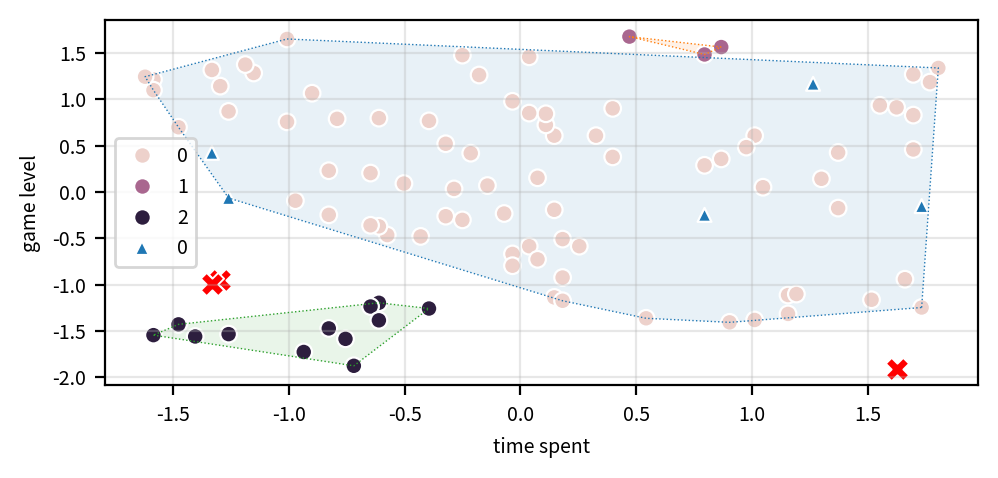

In [19]:
vdf = result_df2.copy()
hue_field = 'cluster'
x_field = 'time spent'
y_field = 'game level'


width_px = 1000
height_px = 480
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 군집별 값의 종류별로 반복
for c in vdf[hue_field].unique():
    # 이상치는 건너뜀
    if c == -1:
        continue
    # 값의 정류별로 데이터프레임을 나눔
    df_c = vdf.loc[vdf[hue_field] == c, [x_field, y_field]]

    try:
        # 외각선 좌표 계산
        hull = ConvexHull(df_c)

        # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points = np.append(hull.vertices, hull.vertices[0])
        ax.plot(# type: ignore
            df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth = 0.5, linestyle = ':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha = 0.1)
    except:
        pass
# 핵심 벡터만 표시
sb.scatterplot(data=vdf[(vdf[hue_field] !=-1) & (vdf['vector'] == 'core')], x = x_field, y = y_field, hue = 'cluster', edgecolor = 'white', linewidth = 0.8)

# 외곽 벡터만 표시
sb.scatterplot(data=vdf[(vdf[hue_field] !=-1) & (vdf['vector'] == 'border')], x = x_field, y = y_field, hue = 'cluster', marker = '^', s = 25,
               edgecolor = 'white', linewidth = 0.8)

# 노이즈 벡터만 표시
sb.scatterplot(data=vdf[(vdf['vector'] =='noise')], x = x_field, y = y_field,color = 'red', marker = 'X', s = 70)
# 그래프 꾸미기
ax.grid(True, alpha = 0.3) 

# 출력
plt.tight_layout()
plt.show()
plt.close()
